In [5]:
from blop.utils import prepare_re_env

%run -i C:\\Users\\megha\\src\\blop\\src\\blop\\utils\\prepare_re_env.py --db-type=temp

bec.disable_plots()

In [3]:
from blop import DOF, Objective, Agent
from blop.utils import functions
from blop.dofs import BrownianMotion

from blop.sim import Beamline

beamline = Beamline(name="bl")

In [4]:
from datetime import datetime

d = datetime(2020, 1, 1)
type(d)

datetime.datetime

In [22]:
pip install -U pymoo

Note: you may need to restart the kernel to use updated packages.  Downloading pymoo-0.6.1.1-cp311-cp311-win_amd64.whl.metadata (5.3 kB)

     ---------------------------------------- 0.0/68.4 kB ? eta -:--:--
     ----------------- ---------------------- 30.7/68.4 kB 1.3 MB/s eta 0:00:01
     -------------------------------------- 68.4/68.4 kB 923.0 kB/s eta 0:00:00
     ---------------------------------------- 0.0/207.3 kB ? eta -:--:--
     -------------------------------------  204.8/207.3 kB 6.3 MB/s eta 0:00:01
     -------------------------------------- 207.3/207.3 kB 4.3 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
   ---------------------------------------- 0.0/896.2 kB ? eta -:--:--
   ----------------------------------- --- 819.2/896.2 kB 17.2 MB/s eta 0:00:01
   --------------------------------------- 896.2/896.2 kB 14.3 MB/s eta 0:00:00
   ---------------------------------------- 0.0/249.1 kB ? eta -

In [7]:
def digestion(df):

    for index, entry in df.iterrows():

        y = entry.x1 ** 2

        if entry.x1 > 4.5: 
            y += 20

        if (entry.x1 > -0.5)  & (entry.x1 < 0.5):
            y -= 20
        
        
        df.loc[index, "y"] = y

    return df

dofs = [DOF(name="x1", search_domain=(-5.0, 5.0))]

objectives = [Objective(name="y", target="min")]

agent = Agent(
    dofs=dofs,
    objectives=objectives,
    verbose=True,
    digestion=digestion,
    db=db,
    tolerate_acquisition_errors=False,
    enforce_all_objectives_valid=True,
    model_inactive_objectives=True, #I thibk we have different versions of blop -- will add the edits tp mine so this works later
    train_every=3,
)

uid, = RE(agent.learn("qr", n=64))

running iteration 1 / 1


Transient Scan ID: 2     Time: 2024-07-17 16:51:59
Persistent Unique Scan ID: 'b6bb28e4-15a8-4eb5-91ed-6b0f3892d3db'
New stream: 'primary'
+-----------+------------+------------+
|   seq_num |       time |         x1 |
+-----------+------------+------------+
|         1 | 16:51:59.6 |      0.068 |
|         2 | 16:51:59.6 |      0.249 |
|         3 | 16:51:59.6 |      0.324 |
|         4 | 16:51:59.6 |      0.612 |
|         5 | 16:51:59.6 |      0.724 |
|         6 | 16:51:59.6 |      4.940 |
|         7 | 16:51:59.7 |      4.750 |
|         8 | 16:51:59.7 |      4.670 |
|         9 | 16:51:59.7 |      4.392 |
|        10 | 16:51:59.7 |      4.268 |
|        11 | 16:51:59.7 |      4.165 |
|        12 | 16:51:59.7 |      3.934 |
|        13 | 16:51:59.7 |      3.880 |
|        14 | 16:51:59.7 |      3.623 |
|        15 | 16:51:59.7 |      3.568 |
|        16 | 16:51:59.7 |      3.332 |
|        17 | 16:51:59.7 |      3.229 |
|        18 | 16:51:59.7 |      3.1

In [8]:
from blop.bayesian.models import construct_single_task_model, train_model

trained models in 0.6 seconds
trained models in 0.7 seconds
trained models in 0.6 seconds
trained models in 0.5 seconds
trained models in 0.6 seconds
trained models in 0.9 seconds
trained models in 0.6 seconds
trained models in 0.8 seconds
trained models in 0.8 seconds
trained models in 0.7 seconds
trained models in 0.6 seconds
trained models in 0.7 seconds
trained models in 0.7 seconds
trained models in 0.9 seconds
trained models in 0.8 seconds
trained models in 0.2 seconds


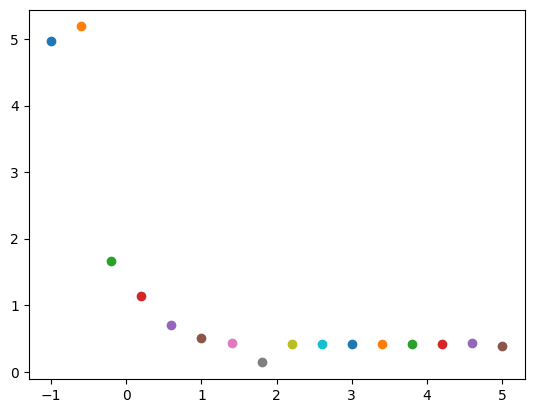

In [9]:
max_x_list = np.linspace(-1, 5, 16)

for max_x in max_x_list:
    
    #agent.dofs.x1.trust_domain = None
    agent.dofs.x1.trust_domain = (-5, max_x)
    
    agent._construct_all_models()
    agent._train_all_models()

    model = agent.objectives.y.model
    
    plt.scatter(max_x, model.covar_module.lengthscales.item() * (max_x + 5))

In [10]:
agent.objectives.y.latent_groups

[]

In [11]:
model.covar_module.lengthscales.item()

0.03914907430816105

In [12]:
model = agent.objectives.y.model

test_x = agent.dofs.transform(agent.sample(n=256))

test_p = model.posterior(test_x)

X = agent.train_inputs()
y = agent.train_targets()["y"].unsqueeze(-1)

mask = ~(X.isnan().any(axis=-1) | y.isnan().any(axis=-1))
#mask &= (X < 0.95).all(axis=-1)

X = X[mask]
y = y[mask]

p = model.posterior(X)

z = (y - p.mean.detach()) / p.variance.sqrt()

In [13]:
from blop.bayesian.models import construct_single_task_model, train_model

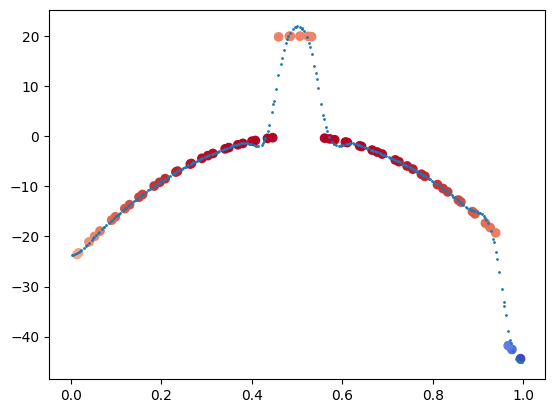

In [14]:
from gpytorch.mlls import ExactMarginalLogLikelihood

mll = ExactMarginalLogLikelihood(model.likelihood, model)

score = mll(model(X), y.unsqueeze(-1)).detach()

plt.scatter(X, y, c=score)
plt.scatter(test_x, test_p.mean.detach(), s=1)

In [15]:
from pymoo.algorithms.soo.nonconvex.ga import GA
from pymoo.operators.crossover.pntx import TwoPointCrossover
from pymoo.operators.mutation.bitflip import BitflipMutation
from pymoo.operators.sampling.rnd import BinaryRandomSampling
from pymoo.optimize import minimize
from pymoo.problems.single.knapsack import create_random_knapsack_problem

import numpy as np
from pymoo.core.problem import ElementwiseProblem

class SubsetProblem(ElementwiseProblem):
    def __init__(self,
                 X,
                 y,
                 n_max
                 ):
        super().__init__(n_var=len(X), n_obj=1)
        self.X = X
        self.y = y
        self.n_max = n_max

    def _evaluate(self, x, out, *args, **kwargs):

        _X = self.X[x]
        _y = self.y[x]

        model = construct_single_task_model(_X, _y, skew_dims=[(0,)])

        train_model(model)

        l = model.covar_module.lengthscales.sum().item() 

        out["F"] = - l * (_X.max() - _X.min())


X = agent.train_inputs()
y = agent.train_targets()["y"].unsqueeze(-1)

n_max = 16
problem = SubsetProblem(X, y, n_max)


In [18]:
from pymoo.core.crossover import Crossover
from pymoo.core.mutation import Mutation
from pymoo.core.sampling import Sampling


class MySampling(Sampling):

    def _do(self, problem, n_samples, **kwargs):
        X = np.full((n_samples, problem.n_var), False, dtype=bool)

        for k in range(n_samples):
            I = np.random.permutation(problem.n_var)[:problem.n_max]
            X[k, I] = True

        return X


class BinaryCrossover(Crossover):
    def __init__(self):
        super().__init__(2, 1)

    def _do(self, problem, X, **kwargs):
        n_parents, n_matings, n_var = X.shape

        _X = np.full((self.n_offsprings, n_matings, problem.n_var), False)

        for k in range(n_matings):
            p1, p2 = X[0, k], X[1, k]

            both_are_true = np.logical_and(p1, p2)
            _X[0, k, both_are_true] = True

            n_remaining = problem.n_max - np.sum(both_are_true)

            I = np.where(np.logical_xor(p1, p2))[0]

            S = I[np.random.permutation(len(I))][:n_remaining]
            _X[0, k, S] = True

        return _X


class MyMutation(Mutation):
    def _do(self, problem, X, **kwargs):
        for i in range(X.shape[0]):
            X[i, :] = X[i, :]
            is_false = np.where(np.logical_not(X[i, :]))[0]
            is_true = np.where(X[i, :])[0]
            X[i, np.random.choice(is_false)] = True
            X[i, np.random.choice(is_true)] = False

        return X

In [19]:
from pymoo.algorithms.soo.nonconvex.ga import GA
from pymoo.optimize import minimize

algorithm = GA(
    pop_size=10,
    sampling=MySampling(),
    crossover=BinaryCrossover(),
    mutation=MyMutation(),
    eliminate_duplicates=True)

res = minimize(problem,
               algorithm,
               ('n_gen', 20),
               seed=1,
               verbose=True)

print("Function value: %s" % res.F[0])
print("Subset:", np.where(res.X)[0])


n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |       10 | -2.220627E-01 | -5.565933E-01
     2 |       20 | -4.003127E-01 | -5.565933E-01
     3 |       30 | -5.597396E-01 | -5.891873E-01
     4 |       40 | -5.839046E-01 | -5.996679E-01
     5 |       50 | -5.901441E-01 | -6.011849E-01
     6 |       60 | -5.982365E-01 | -6.120857E-01
     7 |       70 | -6.038996E-01 | -6.132371E-01
     8 |       80 | -6.048987E-01 | -6.132371E-01
     9 |       90 | -6.096075E-01 | -6.178870E-01
    10 |      100 | -6.128088E-01 | -6.180973E-01


C:\Users\megha\Anaconda3\envs\nsls2\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(


    11 |      110 | -6.147436E-01 | -6.180973E-01
    12 |      120 | -6.167556E-01 | -6.204566E-01


C:\Users\megha\Anaconda3\envs\nsls2\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(


    13 |      130 | -6.184620E-01 | -6.229233E-01
    14 |      140 | -6.184620E-01 | -6.229233E-01
    15 |      150 | -6.187646E-01 | -6.229233E-01
    16 |      160 | -6.199939E-01 | -6.276530E-01
    17 |      170 | -6.222060E-01 | -6.307487E-01
    18 |      180 | -6.228672E-01 | -6.307487E-01
    19 |      190 | -6.230034E-01 | -6.307487E-01
    20 |      200 | -6.230034E-01 | -6.307487E-01
Function value: -0.630748709656894
Subset: [ 4  8  9 14 20 24 27 30 35 38 41 45 49 56 61 62]


In [ ]:
plt.scatter(X, y, c=res.X)